# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
    
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)

In [3]:
# Define global functions here, if required

# Choosing the maximum arm index, tie-break uniformly at random.
def armindex (armlist):
    maxlist= np.argwhere(armlist == armlist.max()).flatten()
    return np.random.choice(maxlist)




## 1. Implement ε-greedy and UCB MABs

In [4]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        assert 0 <= epsilon <= 1, "Epsilon should between 0 and 1."
        self.epsilon = epsilon
        self.Q0 = Q0
        #initialize the count of arms.
        self.count = np.zeros(n_arms, dtype=int)
        #initialize average rewards received
        self.Q = np.full(self.n_arms,self.Q0, dtype=float)
        #tround counter
        self.t_round = 0
    
    def play(self, context=None):
        super().play(context)
        # your code here
               
        # exploit
        if np.random.random() > self.epsilon:
            return armindex(self.Q)
        else:
        # explore
            return np.random.randint(0, self.n_arms)
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
        
        # update count
        self.count[arm] += 1
        count_number = self.count[arm]
        # update Q
        old_Q = self.Q[arm]
        if count_number > 1:
            new_Q = (old_Q * (count_number-1) + reward) / count_number       
        else:
            new_Q = reward
        self.Q[arm] = new_Q
        
        

In [5]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        assert rho > 0 , "rho should be positive."
        self.rho = rho
        self.Q0 = Q0
        #initialize the count of arms.
        self.count = np.zeros(n_arms, dtype=int)
        #initialize average rewards received
        self.rewards = np.full(self.n_arms,self.Q0, dtype=float)
        #tround counter
        self.t_round = 0
        
        
    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        #calculate Q
        Q = np.zeros(self.n_arms)
        #calculate confidence interval
        for arm in range(self.n_arms):
            if self.count[arm] == 0:
                confi_interval = 0
            else:
                
                confi_interval = np.sqrt((self.rho*np.log(self.t_round))/self.count[arm])
                    
        
            Q[arm] = self.rewards[arm] + confi_interval
        
       
        #choose the corresponding arm index of arm with max Q
        return armindex(Q)
    
    
    
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
        self.count[arm] += 1
        old_reward = rewards[arm]
        n = self.count[arm]
        if n == 1:
            new_reward = reward
        else:
            new_reward = (old_reward * (n-1) + reward) / n
        self.rewards[arm] = new_reward
        

## 2. Implement off-policy evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # your code here
    
    
    
    if n_rounds is not None:
        T = n_rounds
    else:
        T = len(arms)
    
    # An initially empty history
    h = []
    # An initially zero total payoff
    R = np.zeros(T, np.float)
    
    t = 0
    
    for tround in range(T):
        arm, reward, context = arms[t], rewards[t], contexts[t]
        
        mab.t_round = tround + 1
        while mab.play(context) != arm:
            t += 1
            if t > len(arms)-1:
                return R
            
            arm, reward, context = arms[t], rewards[t], contexts[t]

        #concatenate the history information
        h.append((context, arm, reward))        
        # update reward
        mab.update(arm, reward, context)
        R[tround] += reward
    
       
    return R    
    
    
        
    

In [7]:
# load dataset here
data = np.loadtxt("dataset.txt", np.int64)
arms, rewards, contexts = data[:, 0], data[:, 1], data[:, 2:]

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.20375


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.205


## 3. Implement LinUCB contextual MAB

In [10]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        # your code here
        assert alpha > 0 , "alpha should be positive."
        self.n_dims = n_dims
        self.alpha = alpha
        #tround counter
        self.t_round = 0
        #initialize a ndims-dimensional identity matrix for n_arms
        self.A = np.array([np.identity(n_dims) for i in range(n_arms)])
        #initialize a ndims-dimensional zero vector for n_arms
        self.b = np.array([np.zeros(n_dims) for i in range(n_arms)])
    
    def play(self, context):
        super().play(context)
        # your code here
        #reshape the context
        re_context = context.reshape(self.n_arms,self.n_dims)
        #calcualate theta for each arm
        theta = np.array([np.dot(np.linalg.inv(self.A[arm]), self.b[arm]) for arm in range(self.n_arms)])
        #initialize P array
        P = np.zeros(self.n_arms)
        
        #calculate p for each arm 
        for arm in range(self.n_arms):  
            interval= np.sqrt(np.linalg.multi_dot([re_context[arm].T, np.linalg.inv(self.A[arm]), re_context[arm]]))
            P[arm] = np.dot(theta[arm].T, re_context[arm]) + self.alpha * interval
        
        #return max arm
        return armindex(P)
            
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        #reshape the context and get corresponding context of the arm.
        re_context = context.reshape(self.n_arms,self.n_dims)
        x = re_context[arm].reshape(1, self.n_dims)
        #update A 
        self.A[arm] += np.dot(x.T,x)
        #update b 
        self.b[arm] += reward * re_context[arm]
        
        

In [11]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.86375


## 4. Implement TreeBootstrap contextual MAB

In [12]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        # your code here
        self.n_dims = n_dims
        self.t_round = 0
        # |Dta|
        self.count = np.zeros(n_arms,dtype=int)
        # Dta
        self.D = [None for i in range (n_arms)]
        # Decision tree sets for all arms
        self.theta = np.array( [tree for arm in range(n_arms)])
        

    def play(self, context):
        super().play(context)
        # your code here
        #reshape the context
        re_context = context.reshape(self.n_arms,self.n_dims)
        # prediction array
        prediction = np.empty(self.n_arms)
        
        for arm in range(self.n_arms):
            # |Dta|
            datasize = self.count[arm]
            # |Dta| = 0
            if datasize == 0:
                prediction[arm] = 1
            
            else:
                
                # Bootstrap
                index = np.random.randint(datasize, size = datasize )
                sample = []
                for i in index:
                    sample.append(self.D[arm][i])
                
                sample = np.array(sample)
                # split the data
                X, y = sample[:, :-1], sample[:,-1]
                # fit model
                self.theta[arm].fit(X,y)
                # probability of success 
                pred= self.theta[arm].predict_proba(re_context[arm].reshape(1, -1))             
                prediction[arm]= pred[0][-1]
        
        return armindex(prediction)
                 
                
                
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        # reshape the context
        re_context = context.reshape(self.n_arms,self.n_dims)
        # update D
        # |Dta| = 0
        if self.count[arm] == 0:
            fabricatefail= re_context[arm].tolist()
            fabricatefail.append(0)
            fabricatesucc= re_context[arm].tolist()
            fabricatesucc.append(1)
            self.D[arm]=[fabricatefail, fabricatesucc]
            self.count[arm] += 2
        else:
            temp = re_context[arm].tolist()
            temp.append(reward)
            self.D[arm].append(temp)
            self.count[arm] += 1
            
            
        
        
        

In [13]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.62125


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

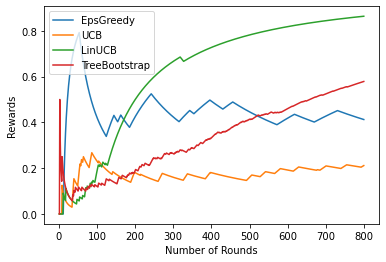

In [14]:
# your code here
# run offlineEvaluate with different classes
rounds= 800
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)

# plot 
x =  np.arange(1, 1 + len(results_EpsGreedy))

plt.plot(x, results_EpsGreedy.cumsum() / x, label = 'EpsGreedy')
plt.plot(x, results_UCB.cumsum() / x, label  = 'UCB')
plt.plot(x,results_LinUCB.cumsum() / x, label = 'LinUCB')
plt.plot(x,results_TreeBootstrap.cumsum() / x, label = 'TreeBootstrap')
plt.xlabel('Number of Rounds')
plt.ylabel('Rewards')
plt.legend()
plt.show()

### 5.B.

The optimized alpha: 0.001


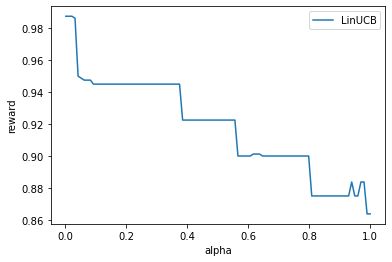

In [15]:
# your code here
# generate 100 possible alphas from 0 to 1
alphas = np.linspace(0.001, 1, 100, dtype=float)

# grid search
scores = np.empty(len(alphas))
for alpha in range(len(alphas)):
    mab = LinUCB(10, 10, alphas[alpha])
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    scores[alpha] = (np.mean(results_LinUCB))
    

index = np.argmax(scores)
print("The optimized alpha: %s" %(alphas[index]))
# plots
plt.plot(alphas,scores,label="LinUCB")

plt.legend()
plt.xlabel('alpha')
plt.ylabel('reward')
plt.show()
    




## 6. Implement KernelUCB contextual MAB

In [16]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        # your code here
        self.n_dims = n_dims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.t_round = 0
        
        self.Kern_matrix_inverse = None
        # store x history and y
        self.x =[]
        self.y =[]
    
    def play(self, context):
        super().play(context)
        # your code here
        # reshape context
        re_context = context.reshape(self.n_arms, self.n_dims)
        # initialize u if at round 1
        u = np.zeros(self.n_arms)
        if self.t_round == 1:
            
            u[0] = 1
            return 0
             
        else:
            # calculate sigma_t and u_t 
            for arm in range(self.n_arms):
                armcontext= re_context[arm].reshape(1, self.n_dims)
                kxt= self.kern(armcontext, self.x)
                sigma = np.sqrt(self.kern(armcontext, armcontext) - np.linalg.multi_dot((kxt, self.Kern_matrix_inverse, kxt.T)))
                uat = np.linalg.multi_dot((kxt, self.Kern_matrix_inverse, self.y)) + self.eta * sigma / np.sqrt(self.gamma)
                u[arm] = uat
            
        return armindex(u)   
      
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        # reshape context
        start = arm * self.n_dims
        re_context= context[start:start + self.n_dims]
        armcontext = re_context.reshape(1, self.n_dims)
        # initilize kernel matrix inverse
        if self.t_round == 1:
            self.Kern_matrix_inverse  = np.linalg.inv((self.kern(armcontext, armcontext) + self.gamma ))
        else:
            # online update of kernel matrix inverse
            b = self.kern(armcontext, self.x)
            K22 = np.linalg.inv(self.kern(armcontext, armcontext) + self.gamma - np.linalg.multi_dot((b,self.Kern_matrix_inverse, b.T)))
            K11 = self.Kern_matrix_inverse + np.linalg.multi_dot((K22, self.Kern_matrix_inverse, b, b.T, self.Kern_matrix_inverse))
            K12 = np.linalg.multi_dot((-K22 , self.Kern_matrix_inverse, b))
            K21 = np.linalg.multi_dot((-K22 , b.T, self.Kern_matrix_inverse))
            
            # block matrix
            self.Kern_matrix_inverse = np.block([[K11, K12], [K21, K22]])
        start = arm * self.n_dims
        self.x.append(re_context)
        self.y.append(reward)        

In [ ]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

In [ ]:
# your plotting code here
# plot 
x =  np.arange(1, 1 + len(results_EpsGreedy))

plt.plot(x,results_LinUCB.cumsum() / x, label = 'LinUCB')
plt.plot(x,results_KernelUCB.cumsum() / x, label = 'KernelUCB')
plt.xlabel('Number of Rounds')
plt.ylabel('Rewards')
plt.legend()
plt.show()